In [18]:
import os
import glob
import numpy as np
import nibabel as nib
import re
import pydicom
from scipy.ndimage import zoom
from PIL import Image
import matplotlib.pyplot as plt
import random

import sys

from nnunetv2.imageio.simpleitk_reader_writer import SimpleITKIO
from nnunetv2.evaluation.evaluate_predictions import labels_to_list_of_regions, compute_metrics, save_summary_json, region_or_label_to_mask, compute_tp_fp_fn_tn
from nnunetv2.utilities.json_export import recursive_fix_for_json_export
from batchgenerators.utilities.file_and_folder_operations import join




In [2]:
os.environ["ITK_NIFTI_SFORM_PERMISSIVE"] = "1"

In [3]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Compute DSC Test

In [40]:
def compute_other_DSC(pred_folder,  pred_files, gt_files):
    image_reader_writer = SimpleITKIO()
    regions = labels_to_list_of_regions([0, 1, 2, 3, 4])

    results = []
    dices = []
    for region in regions:
        dices_class = []
        for j, k in zip(gt_files, pred_files):
            seg_ref, seg_ref_dict = image_reader_writer.read_seg(j)
            seg_pred, seg_pred_dict = image_reader_writer.read_seg(k)
            print(seg_ref.shape)
            for item in range(seg_ref.shape[1]):
                mask_ref = region_or_label_to_mask(np.expand_dims(seg_ref[:, item, :, :], 0), region)
                mask_pred = region_or_label_to_mask(np.expand_dims(seg_pred[:, item, :, :], 0), region)
                tp, fp, fn, tn = compute_tp_fp_fn_tn(mask_ref, mask_pred, None)
                if tp + fp + fn == 0:
                    dices_class.append(np.nan)
                else:
                    dices_class.append(2 * tp / (2 * tp + fp + fn))
        print(dices_class)
        without_nan = np.where(np.isnan(np.array(dices_class)), 1.0, np.array(dices_class))
        dices.append(np.mean(without_nan))
        # dices.append(np.nanmean(np.array(dices_class)))
    print(dices)
    return dices


In [15]:
def compute_DSC_fold(pred_folder,  pred_files, gt_files):

    image_reader_writer = SimpleITKIO()
    regions = labels_to_list_of_regions([0, 1, 2, 3, 4])

    results = []
    for j, k in zip(gt_files, pred_files):
        results.append(compute_metrics(j, k, image_reader_writer, regions, None))
    print(results)

    # mean metric per class
    metric_list = list(results[0]['metrics'][regions[0]].keys())
    means = {}
    for r in regions:
        means[r] = {}
        for m in metric_list:
            means[r][m] = np.nanmean([i['metrics'][r][:][m] for i in results])
            # values = [i['metrics'][r][m] for i in results]
            # # Replace NaN values with 1
            # values = np.where(np.isnan(values), 1.0, values)
            # # Calculate the mean, including NaN values now treated as 1
            # means[r][m] = np.mean(values)

    # foreground mean
    foreground_mean = {}
    for m in metric_list:
        values = []
        for k in means.keys():
            if k == 0 or k == '0':
                continue
            values.append(means[k][m])
        foreground_mean[m] = np.mean(values)

    [recursive_fix_for_json_export(i) for i in results]
    recursive_fix_for_json_export(means)
    recursive_fix_for_json_export(foreground_mean)
    result = {'metric_per_case': results, 'mean': means, 'foreground_mean': foreground_mean}
    output_file = join(pred_folder, 'summary.json')
    save_summary_json(result, output_file)
    return result

    

In [13]:
def get_and_check_files(pred_folder, gt_dir, test_cases, img_dir, type):
    gt_files = []
    img_files = []
    # print(gt_dir)
    # print(img_dir)
    for i in test_cases:
        gt_files += glob.glob(os.path.join(gt_dir, f"{type}_{i}.nii.gz")) 
        img_files += glob.glob(os.path.join(img_dir, f"{type}_{i}.npz")) 

    gt_files = sorted(gt_files)
    img_files = sorted(img_files)
    pred_files = sorted(glob.glob(os.path.join(pred_folder, "*.nii.gz")))
    # print(gt_files)
    # print(img_files)
    # print(pred_files)

    # print(len(gt_files))
    # print(len(img_dir))
    # print(len(pred_files))
    assert len(gt_files) == len(img_files) == len(pred_files)
    
    # print()

    for j, k, z in zip(gt_files, pred_files, img_files):
        new_j = re.sub(pred_folder, gt_dir, k)
        new_j2 = re.sub("nnUNetPlans_2d", "gt_segmentations", z)
        new_j3 = re.sub(".npz", ".nii.gz", new_j2)
        if not new_j == new_j3 == j:
            print("HERE??")
            print(j)
            print(new_j)
            print(new_j3)
        
        
    
    return gt_files, pred_files, img_files

In [41]:
pred_folder_0 = "nnUNet_results/Dataset038_T1/nnUNetTrainer__nnUNetResEncUNetLPlans__2d/test_postprocessed/fold_0/"
gt_dir = "nnUNet_preprocessed/Dataset038_T1/gt_segmentations/"
img_dir = "nnUNet_preprocessed/Dataset038_T1/nnUNetPlans_2d/"
test_cases_0 = [2, 3, 13, 16]

gt_files, pred_files, images = get_and_check_files(pred_folder_0, gt_dir, test_cases_0, img_dir, "T1")
results0 = compute_other_DSC(pred_folder_0, pred_files, gt_files)
print(results0)

(1, 30, 288, 288)
(1, 38, 256, 256)
(1, 26, 288, 288)
(1, 33, 256, 256)
[0.9998613330117867, 0.9995208258778288, 0.9988329392211855, 0.9987640276710222, 0.9986602539960857, 0.9987379205384872, 0.998253545550257, 0.9975673327541269, 0.9981789576700568, 0.9978901391767842, 0.997299829852292, 0.9966538604535878, 0.9976743604491235, 0.9951042956472045, 0.996842870094714, 0.9967884878643769, 0.9968493275527608, 0.995529759309748, 0.9919361183227126, 0.9894586856999618, 0.9920028341063708, 0.9901174085649126, 0.992123211747369, 0.9949700784151878, 0.9985610784338474, 0.9986641897223378, 0.9986843957092942, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999847409781033, 1.0, 0.9996336549029186, 0.9879782264602556, 0.9843159134585581, 0.9833232497168831, 0.9783704996999151, 0.9739639597325944, 0.97378722871191, 0.9718794857514884, 0.9689680398341816, 0.9719278705497557, 0.9684568406472329, 0.9616984719161901, 0.9593980624534244, 0.969780460419968, 0.9700564385442527, 0.9640914913672948, 0.9710542792467369, 0.983

In [20]:
def show_results(gt_files, pred_files, images):
    i=0
    for true_file, pred_file, image_file in zip(gt_files, pred_files, images):
        # print(true_file)
        seg_pred = nib.load(pred_file).get_fdata()
        seg_true = nib.load(true_file).get_fdata()
        image_data = np.load(image_file)
        # print(np.unique(image_data))

        fig = plt.figure("visualize")
        plt.figure(figsize=(5, 2.5))
        plt.subplot(1, 3, 1)
        plt.axis("off")
        plt.title("Image")
        plt.imshow(image_data.squeeze().T, cmap="gray")
        plt.subplot(1, 3, 2)
        plt.axis("off")
        plt.title("Prediction")
        plt.imshow(seg_pred)
        plt.subplot(1, 3, 3)
        plt.axis("off")
        plt.title("Ground Truth")
        plt.imshow(seg_true)
        plt.show()
        if i == 10:
            break
        else:
            i += 1


# T1 - T1

In [7]:
sys.stderr = open(os.devnull, 'w')

In [21]:
# CLEAN
#  fold 0
pred_folder_0 = "nnUNet_results/Dataset038_T1/nnUNetTrainer__nnUNetResEncUNetLPlans__2d/test_postprocessed/fold_0/"
gt_dir = "nnUNet_preprocessed/Dataset038_T1/gt_segmentations/"
img_dir = "nnUNet_preprocessed/Dataset038_T1/nnUNetPlans_2d/"
test_cases_0 = [2, 3, 13, 16]

gt_files, pred_files, images = get_and_check_files(pred_folder_0, gt_dir, test_cases_0, img_dir, "T1")
results0 = compute_DSC_fold(pred_folder_0, pred_files, gt_files)
res_0 = results0["mean"]
print(res_0)
# fold 1
pred_folder_1 = "nnUNet_results/Dataset038_T1/nnUNetTrainer__nnUNetResEncUNetLPlans__2d/test_postprocessed/fold_1/"
test_cases_1 = [0, 4, 5, 14]

gt_files, pred_files, images = get_and_check_files(pred_folder_1, gt_dir, test_cases_1, img_dir, "T1")
results1 = compute_DSC_fold(pred_folder_1, pred_files, gt_files)
res_1 = results1["mean"]
print(res_1)
# fold 2
pred_folder_2 = "nnUNet_results/Dataset038_T1/nnUNetTrainer__nnUNetResEncUNetLPlans__2d/test_postprocessed/fold_2/"
test_cases_2 = [8, 11, 17, 18]

gt_files, pred_files, images = get_and_check_files(pred_folder_2, gt_dir, test_cases_2, img_dir, "T1")
results2 = compute_DSC_fold(pred_folder_2, pred_files, gt_files)
res_2 = results2["mean"]
print(res_2)
# fold 3
pred_folder_3 = "nnUNet_results/Dataset038_T1/nnUNetTrainer__nnUNetResEncUNetLPlans__2d/test_postprocessed/fold_3/"
test_cases_3 = [1, 7, 9, 10]

gt_files, pred_files, images = get_and_check_files(pred_folder_3, gt_dir, test_cases_3, img_dir, "T1")
results3 = compute_DSC_fold(pred_folder_3, pred_files, gt_files)
res_3 = results3["mean"]
print(res_3)
# fold 4
pred_folder_4 = "nnUNet_results/Dataset038_T1/nnUNetTrainer__nnUNetResEncUNetLPlans__2d/test_postprocessed/fold_4/"
test_cases_4 = [6, 12, 15, 19]

gt_files, pred_files, images = get_and_check_files(pred_folder_4, gt_dir, test_cases_4, img_dir, "T1")
results4 = compute_DSC_fold(pred_folder_4, pred_files, gt_files)
res_4 = results4["mean"]
print(res_4)

# show_results(gt_files, pred_files, images)

class_0 = np.array([res_0[(0,)]["Dice"], res_1[(0,)]["Dice"], res_2[(0,)]["Dice"], res_3[(0,)]["Dice"], res_4[(0,)]["Dice"]])
print(class_0)
print(np.mean(class_0))
print(np.std(class_0))

class_1 = np.array([res_0[(1,)]["Dice"], res_1[(1,)]["Dice"], res_2[(1,)]["Dice"], res_3[(1,)]["Dice"], res_4[(1,)]["Dice"]])
print(class_1)
print(np.mean(class_1))
print(np.std(class_1))

class_2 = np.array([res_0[(2,)]["Dice"], res_1[(2,)]["Dice"], res_2[(2,)]["Dice"], res_3[(2,)]["Dice"], res_4[(2,)]["Dice"]])
print(class_2)
print(np.mean(class_2))
print(np.std(class_2))

class_3 = np.array([res_0[(3,)]["Dice"], res_1[(3,)]["Dice"], res_2[(3,)]["Dice"], res_3[(3,)]["Dice"], res_4[(3,)]["Dice"]])
print(class_3)
print(np.mean(class_3))
print(np.std(class_3))

class_4 = np.array([res_0[(4,)]["Dice"], res_1[(4,)]["Dice"], res_2[(4,)]["Dice"], res_3[(4,)]["Dice"], res_4[(4,)]["Dice"]])
print(class_4)
print(np.mean(class_4))
print(np.std(class_4))

mean_total = (np.mean(class_0) + np.mean(class_1) + np.mean(class_2) + np.mean(class_3) + np.mean(class_4)) / 5

print("Overall mean: ", mean_total)

{(0,): {'Dice': 0.9934915730171181, 'IoU': 0.9871044031979463, 'FP': 15454.5, 'TP': 2217884.0, 'FN': 14294.0, 'TN': 76847.5, 'n_pred': 2233338.5, 'n_ref': 2232178.0}, (1,): {'Dice': 0.9353061400674398, 'IoU': 0.8785331833670641, 'FP': 2625.0, 'TP': 58427.25, 'FN': 5456.5, 'TN': 2257971.25, 'n_pred': 61052.25, 'n_ref': 63883.75}, (2,): {'Dice': 0.4609689530936504, 'IoU': 0.4198222022344059, 'FP': 302.75, 'TP': 3820.5, 'FN': 3873.0, 'TN': 2316483.75, 'n_pred': 4123.25, 'n_ref': 7693.5}, (3,): {'Dice': 0.4538148558740899, 'IoU': 0.4156652028063925, 'FP': 161.75, 'TP': 5060.75, 'FN': 4320.0, 'TN': 2314937.5, 'n_pred': 5222.5, 'n_ref': 9380.75}, (4,): {'Dice': 0.7249337870721797, 'IoU': 0.6384770322766472, 'FP': 11412.5, 'TP': 9331.0, 'FN': 2013.0, 'TN': 2301723.5, 'n_pred': 20743.5, 'n_ref': 11344.0}}
{(0,): {'Dice': 0.9965420405040519, 'IoU': 0.9931143808229574, 'FP': 12262.75, 'TP': 2236336.25, 'FN': 4584.5, 'TN': 114816.5, 'n_pred': 2248599.0, 'n_ref': 2240920.75}, (1,): {'Dice': 0.9517

# T2 - T2

In [11]:
# fold 0
pred_folder_0 = "nnUNet_results/Dataset036_CHAOST2/nnUNetTrainer__nnUNetResEncUNetLPlans__2d/fold_0/test_postprocessed/"
gt_dir = "nnUNet_preprocessed/Dataset036_CHAOST2/gt_segmentations/"
img_dir = "nnUNet_preprocessed/Dataset036_CHAOST2/nnUNetPlans_2d/"
test_cases_0 = [4, 12, 14, 16]

gt_files, pred_files, images = get_and_check_files(pred_folder_0, gt_dir, test_cases_0, img_dir, "CHAOST2")
results0 = compute_DSC_fold(pred_folder_0, pred_files, gt_files)
res_0 = results0["mean"]
print(res_0)
# fold 1
pred_folder_1 = "nnUNet_results/Dataset036_CHAOST2/nnUNetTrainer__nnUNetResEncUNetLPlans__2d/fold_1/test_postprocessed/"
test_cases_1 = [1, 6, 11, 17]

gt_files, pred_files, images = get_and_check_files(pred_folder_1, gt_dir, test_cases_1, img_dir, "CHAOST2")
results1 = compute_DSC_fold(pred_folder_1, pred_files, gt_files)
res_1 = results1["mean"]
print(res_1)
# fold 2
pred_folder_2 = "nnUNet_results/Dataset036_CHAOST2/nnUNetTrainer__nnUNetResEncUNetLPlans__2d/fold_2/test_postprocessed/"
test_cases_2 = [2, 9, 10, 19]

gt_files, pred_files, images = get_and_check_files(pred_folder_2, gt_dir, test_cases_2, img_dir, "CHAOST2")
results2 = compute_DSC_fold(pred_folder_2, pred_files, gt_files)
res_2 = results2["mean"]
print(res_2)
# fold 3
pred_folder_3 = "nnUNet_results/Dataset036_CHAOST2/nnUNetTrainer__nnUNetResEncUNetLPlans__2d/fold_3/test_postprocessed/"
test_cases_3 = [3, 7, 8, 13]

gt_files, pred_files, images = get_and_check_files(pred_folder_3, gt_dir, test_cases_3, img_dir, "CHAOST2")
results3 = compute_DSC_fold(pred_folder_3, pred_files, gt_files)
res_3 = results3["mean"]
print(res_3)
# fold 4
pred_folder_4 = "nnUNet_results/Dataset036_CHAOST2/nnUNetTrainer__nnUNetResEncUNetLPlans__2d/fold_4/test_postprocessed/"
test_cases_4 = [0, 5, 15, 18]

gt_files, pred_files, images = get_and_check_files(pred_folder_4, gt_dir, test_cases_4, img_dir, "CHAOST2")
results4 = compute_DSC_fold(pred_folder_4, pred_files, gt_files)
res_4 = results4["mean"]
print(res_4)

# show_results(gt_files, pred_files, images)

class_0 = np.array([res_0[(0,)]["Dice"], res_1[(0,)]["Dice"], res_2[(0,)]["Dice"], res_3[(0,)]["Dice"], res_4[(0,)]["Dice"]])
print(class_0)
print(np.mean(class_0))
print(np.std(class_0))

class_1 = np.array([res_0[(1,)]["Dice"], res_1[(1,)]["Dice"], res_2[(1,)]["Dice"], res_3[(1,)]["Dice"], res_4[(1,)]["Dice"]])
print(class_1)
print(np.mean(class_1))
print(np.std(class_1))

class_2 = np.array([res_0[(2,)]["Dice"], res_1[(2,)]["Dice"], res_2[(2,)]["Dice"], res_3[(2,)]["Dice"], res_4[(2,)]["Dice"]])
print(class_2)
print(np.mean(class_2))
print(np.std(class_2))

class_3 = np.array([res_0[(3,)]["Dice"], res_1[(3,)]["Dice"], res_2[(3,)]["Dice"], res_3[(3,)]["Dice"], res_4[(3,)]["Dice"]])
print(class_3)
print(np.mean(class_3))
print(np.std(class_3))

class_4 = np.array([res_0[(4,)]["Dice"], res_1[(4,)]["Dice"], res_2[(4,)]["Dice"], res_3[(4,)]["Dice"], res_4[(4,)]["Dice"]])
print(class_4)
print(np.mean(class_4))
print(np.std(class_4))

mean_total = (np.mean(class_0) + np.mean(class_1) + np.mean(class_2) + np.mean(class_3) + np.mean(class_4)) / 5

print("Overall mean: ", mean_total)
mean_01 = (np.mean(class_0) + np.mean(class_1)) / 2
mean_02 = (np.mean(class_0) + np.mean(class_2)) / 2
mean_03 = (np.mean(class_0) + np.mean(class_3)) / 2
mean_04 = (np.mean(class_0) + np.mean(class_4)) / 2


print("Overall mean: ", mean_total)

print("01 mean: ", mean_01)

print("02 mean: ", mean_02)

print("03 mean: ", mean_03)

print("04 mean: ", mean_04)

{(0,): {'Dice': 0.9971328244691927, 'IoU': 0.9943110721206069, 'FP': 399.48854961832063, 'TP': 149992.45801526718, 'FN': 325.59541984732823, 'TN': 5893.732824427481, 'n_pred': 150391.9465648855, 'n_ref': 150318.0534351145}, (1,): {'Dice': 0.8997981587030472, 'IoU': 0.873498532149209, 'FP': 186.16030534351145, 'TP': 4493.839694656489, 'FN': 217.5114503816794, 'TN': 151713.76335877864, 'n_pred': 4680.0, 'n_ref': 4711.3511450381675}, (2,): {'Dice': 0.8763571855601349, 'IoU': 0.8601752798671085, 'FP': 16.045801526717558, 'TP': 405.76335877862596, 'FN': 70.19083969465649, 'TN': 156119.2748091603, 'n_pred': 421.80916030534354, 'n_ref': 475.9541984732824}, (3,): {'Dice': 0.8589377293572347, 'IoU': 0.8396533305775483, 'FP': 27.480916030534353, 'TP': 400.587786259542, 'FN': 77.43511450381679, 'TN': 156105.77099236642, 'n_pred': 428.0687022900763, 'n_ref': 478.0229007633588}, (4,): {'Dice': 0.8134841523548048, 'IoU': 0.7967074288280444, 'FP': 111.49618320610686, 'TP': 577.9541984732824, 'FN': 49

In [ ]:
test_cases_0 = [4, 12, 14, 16]
test_cases_1 = [1, 6, 11, 17]
test_cases_2 = [2, 9, 10, 19]
test_cases_3 = [3, 7, 8, 13]
test_cases_4 = [0, 5, 15, 18]

# No Adaptation T1 - T2

{(1,): {'Dice': 0.19668837273106426, 'IoU': 0.14753844146986414, 'FP': 1953.526717557252, 'TP': 1800.1374045801526, 'FN': 2911.2137404580153, 'TN': 149946.3969465649, 'n_pred': 3753.664122137405, 'n_ref': 4711.3511450381675}, (2,): {'Dice': 0.0, 'IoU': 0.0, 'FP': 0.0, 'TP': 0.0, 'FN': 475.9541984732824, 'TN': 156135.32061068702, 'n_pred': 0.0, 'n_ref': 475.9541984732824}, (3,): {'Dice': 0.0, 'IoU': 0.0, 'FP': 3.618320610687023, 'TP': 0.0, 'FN': 478.0229007633588, 'TN': 156129.63358778626, 'n_pred': 3.618320610687023, 'n_ref': 478.0229007633588}, (4,): {'Dice': 0.00019597207397945794, 'IoU': 9.863357275458911e-05, 'FP': 144.34351145038167, 'TP': 0.21374045801526717, 'FN': 627.6793893129772, 'TN': 155839.03816793894, 'n_pred': 144.55725190839695, 'n_ref': 627.8931297709923}}
{(1,): {'Dice': 0.35396389741307566, 'IoU': 0.2830154252879042, 'FP': 781.8110236220473, 'TP': 2028.267716535433, 'FN': 2004.1259842519685, 'TN': 112196.14173228346, 'n_pred': 2810.0787401574803, 'n_ref': 4032.393700

<Figure size 640x480 with 0 Axes>

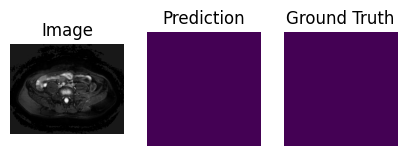

<Figure size 640x480 with 0 Axes>

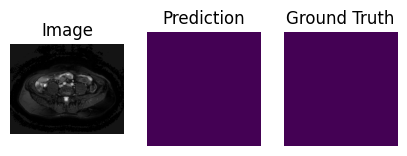

<Figure size 640x480 with 0 Axes>

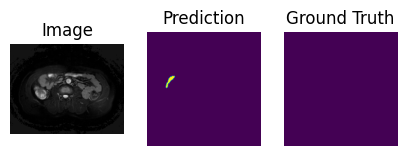

<Figure size 640x480 with 0 Axes>

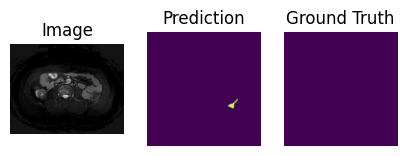

<Figure size 640x480 with 0 Axes>

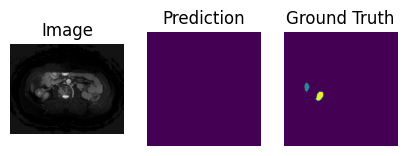

<Figure size 640x480 with 0 Axes>

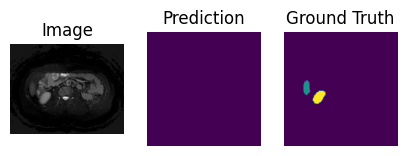

[0.19668837 0.3539639  0.04449366 0.1697435  0.25203035]
0.2033839572292239
0.10145287332425916
[0. 0. 0. 0. 0.]
0.0
0.0
[0.         0.00059025 0.         0.         0.        ]
0.00011804950453692829
0.00023609900907385658
[0.00019597 0.         0.         0.00073356 0.        ]
0.000185906492343704
0.0002841512895490692


In [28]:
# fold 0
pred_folder_0 = "nnUNet_results/Dataset035_CHAOST1/nnUNetTrainer__nnUNetResEncUNetLPlans__2d/test_NA/fold_0/test_postprocessed/"
gt_dir = "nnUNet_preprocessed/Dataset036_CHAOST2/gt_segmentations/"
img_dir = "nnUNet_preprocessed/Dataset036_CHAOST2/nnUNetPlans_2d/"
test_cases_0 = [4, 12, 14, 16]


gt_files, pred_files, images = get_and_check_files(pred_folder_0, gt_dir, test_cases_0, img_dir, "CHAOST2")
results0 = compute_DSC_fold(pred_folder_0, pred_files, gt_files)
res_0 = results0["mean"]
print(res_0)
# fold 1
pred_folder_1 = "nnUNet_results/Dataset035_CHAOST1/nnUNetTrainer__nnUNetResEncUNetLPlans__2d/test_NA/fold_1/test_postprocessed/"
test_cases_1 = [1, 6, 11, 17]

gt_files, pred_files, images = get_and_check_files(pred_folder_1, gt_dir, test_cases_1, img_dir, "CHAOST2")
results1 = compute_DSC_fold(pred_folder_1, pred_files, gt_files)
res_1 = results1["mean"]
print(res_1)
# fold 2
pred_folder_2 = "nnUNet_results/Dataset035_CHAOST1/nnUNetTrainer__nnUNetResEncUNetLPlans__2d/test_NA/fold_2/test_postprocessed/"
test_cases_2 = [2, 9, 10, 19]

gt_files, pred_files, images = get_and_check_files(pred_folder_2, gt_dir, test_cases_2, img_dir, "CHAOST2")
results2 = compute_DSC_fold(pred_folder_2, pred_files, gt_files)
res_2 = results2["mean"]
print(res_2)
# fold 3
pred_folder_3 = "nnUNet_results/Dataset035_CHAOST1/nnUNetTrainer__nnUNetResEncUNetLPlans__2d/test_NA/fold_3/test_postprocessed/"
test_cases_3 = [3, 7, 8, 13]

gt_files, pred_files, images = get_and_check_files(pred_folder_3, gt_dir, test_cases_3, img_dir, "CHAOST2")
results3 = compute_DSC_fold(pred_folder_3, pred_files, gt_files)
res_3 = results3["mean"]
print(res_3)
# fold 4
pred_folder_4 = "nnUNet_results/Dataset035_CHAOST1/nnUNetTrainer__nnUNetResEncUNetLPlans__2d/test_NA/fold_4/test_postprocessed/"
test_cases_4 = [0, 5, 15, 18] 

gt_files, pred_files, images = get_and_check_files(pred_folder_4, gt_dir, test_cases_4, img_dir, "CHAOST2")
results4 = compute_DSC_fold(pred_folder_4, pred_files, gt_files)
res_4 = results4["mean"]
print(res_4)

show_results(gt_files, pred_files, images)

class_1 = np.array([res_0[(1,)]["Dice"], res_1[(1,)]["Dice"], res_2[(1,)]["Dice"], res_3[(1,)]["Dice"], res_4[(1,)]["Dice"]])
print(class_1)
print(np.mean(class_1))
print(np.std(class_1))

class_2 = np.array([res_0[(2,)]["Dice"], res_1[(2,)]["Dice"], res_2[(2,)]["Dice"], res_3[(2,)]["Dice"], res_4[(2,)]["Dice"]])
print(class_2)
print(np.mean(class_2))
print(np.std(class_2))

class_3 = np.array([res_0[(3,)]["Dice"], res_1[(3,)]["Dice"], res_2[(3,)]["Dice"], res_3[(3,)]["Dice"], res_4[(3,)]["Dice"]])
print(class_3)
print(np.mean(class_3))
print(np.std(class_3))

class_4 = np.array([res_0[(4,)]["Dice"], res_1[(4,)]["Dice"], res_2[(4,)]["Dice"], res_3[(4,)]["Dice"], res_4[(4,)]["Dice"]])
print(class_4)
print(np.mean(class_4))
print(np.std(class_4))

# T2 - T1

In [ ]:
test_cases_0 = [0, 2, 4, 12]
test_cases_1 = [1, 9, 16, 18]
test_cases_2 = [6, 8, 13, 14]
test_cases_3 = [3, 7, 10, 11]
test_cases_4 = [5, 15, 17, 19]

{(1,): {'Dice': 0.02043078479035431, 'IoU': 0.01757848402339289, 'FP': 75.4453125, 'TP': 30.5625, 'FN': 3766.953125, 'TN': 113496.765625, 'n_pred': 106.0078125, 'n_ref': 3797.515625}, (2,): {'Dice': 0.0, 'IoU': 0.0, 'FP': 1.3515625, 'TP': 0.0, 'FN': 415.6015625, 'TN': 116952.7734375, 'n_pred': 1.3515625, 'n_ref': 415.6015625}, (3,): {'Dice': 0.0011767388154652898, 'IoU': 0.0006102724103471687, 'FP': 0.1875, 'TP': 0.625, 'FN': 454.3359375, 'TN': 116914.578125, 'n_pred': 0.8125, 'n_ref': 454.9609375}, (4,): {'Dice': 0.0, 'IoU': 0.0, 'FP': 1.1015625, 'TP': 0.0, 'FN': 437.765625, 'TN': 116930.859375, 'n_pred': 1.1015625, 'n_ref': 437.765625}}
{(1,): {'Dice': 0.01566822805444082, 'IoU': 0.012616531592779884, 'FP': 10.11111111111111, 'TP': 17.555555555555557, 'FN': 3241.8055555555557, 'TN': 112029.34722222222, 'n_pred': 27.666666666666668, 'n_ref': 3259.3611111111113}, (2,): {'Dice': 0.0, 'IoU': 0.0, 'FP': 0.0, 'TP': 0.0, 'FN': 329.93055555555554, 'TN': 114968.88888888889, 'n_pred': 0.0, 'n_

<Figure size 640x480 with 0 Axes>

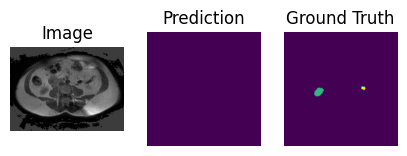

<Figure size 640x480 with 0 Axes>

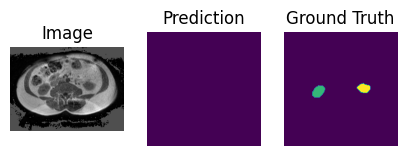

<Figure size 640x480 with 0 Axes>

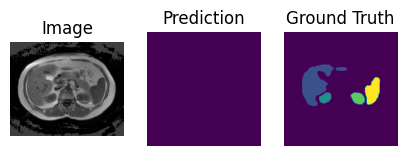

<Figure size 640x480 with 0 Axes>

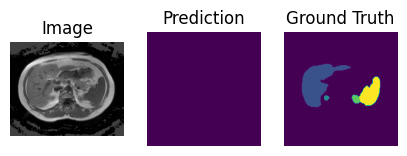

<Figure size 640x480 with 0 Axes>

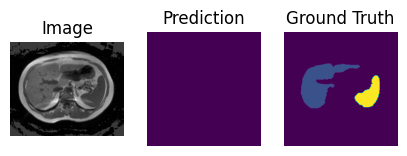

<Figure size 640x480 with 0 Axes>

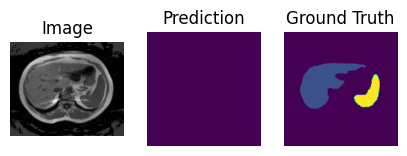

[0.02043078 0.01566823 0.03066919 0.07225556 0.03230448]
0.03426564801430544
0.01998640168371004
[0. 0. 0. 0. 0.]
0.0
0.0
[0.00117674 0.         0.         0.         0.        ]
0.00023534776309305796
0.0004706955261861159
[0. 0. 0. 0. 0.]
0.0
0.0


In [29]:
# fold 0
pred_folder_0 = "nnUNet_results/Dataset036_CHAOST2/nnUNetTrainer__nnUNetResEncUNetLPlans__2d/test_NA/fold_0/test_postprocessed/"
gt_dir = "nnUNet_preprocessed/Dataset035_CHAOST1/gt_segmentations/"
img_dir = "nnUNet_preprocessed/Dataset035_CHAOST1/nnUNetPlans_2d/"
test_cases_0 = [0, 2, 4, 12]


gt_files, pred_files, images = get_and_check_files(pred_folder_0, gt_dir, test_cases_0, img_dir, "CHAOST1")
results0 = compute_DSC_fold(pred_folder_0, pred_files, gt_files)
res_0 = results0["mean"]
print(res_0)
# fold 1
pred_folder_1 = "nnUNet_results/Dataset036_CHAOST2/nnUNetTrainer__nnUNetResEncUNetLPlans__2d/test_NA/fold_1/test_postprocessed/"
test_cases_1 = [1, 9, 16, 18]

gt_files, pred_files, images = get_and_check_files(pred_folder_1, gt_dir, test_cases_1, img_dir, "CHAOST1")
results1 = compute_DSC_fold(pred_folder_1, pred_files, gt_files)
res_1 = results1["mean"]
print(res_1)
# fold 2
pred_folder_2 = "nnUNet_results/Dataset036_CHAOST2/nnUNetTrainer__nnUNetResEncUNetLPlans__2d/test_NA/fold_2/test_postprocessed/"
test_cases_2 = [6, 8, 13, 14]

gt_files, pred_files, images = get_and_check_files(pred_folder_2, gt_dir, test_cases_2, img_dir, "CHAOST1")
results2 = compute_DSC_fold(pred_folder_2, pred_files, gt_files)
res_2 = results2["mean"]
print(res_2)
# fold 3
pred_folder_3 = "nnUNet_results/Dataset036_CHAOST2/nnUNetTrainer__nnUNetResEncUNetLPlans__2d/test_NA/fold_3/test_postprocessed/"
test_cases_3 = [3, 7, 10, 11]

gt_files, pred_files, images = get_and_check_files(pred_folder_3, gt_dir, test_cases_3, img_dir, "CHAOST1")
results3 = compute_DSC_fold(pred_folder_3, pred_files, gt_files)
res_3 = results3["mean"]
print(res_3)
# fold 4
pred_folder_4 = "nnUNet_results/Dataset036_CHAOST2/nnUNetTrainer__nnUNetResEncUNetLPlans__2d/test_NA/fold_4/test_postprocessed/"
test_cases_4 = [5, 15, 17, 19]

gt_files, pred_files, images = get_and_check_files(pred_folder_4, gt_dir, test_cases_4, img_dir, "CHAOST1")
results4 = compute_DSC_fold(pred_folder_4, pred_files, gt_files)
res_4 = results4["mean"]
print(res_4)

show_results(gt_files, pred_files, images)

class_1 = np.array([res_0[(1,)]["Dice"], res_1[(1,)]["Dice"], res_2[(1,)]["Dice"], res_3[(1,)]["Dice"], res_4[(1,)]["Dice"]])
print(class_1)
print(np.mean(class_1))
print(np.std(class_1))

class_2 = np.array([res_0[(2,)]["Dice"], res_1[(2,)]["Dice"], res_2[(2,)]["Dice"], res_3[(2,)]["Dice"], res_4[(2,)]["Dice"]])
print(class_2)
print(np.mean(class_2))
print(np.std(class_2))

class_3 = np.array([res_0[(3,)]["Dice"], res_1[(3,)]["Dice"], res_2[(3,)]["Dice"], res_3[(3,)]["Dice"], res_4[(3,)]["Dice"]])
print(class_3)
print(np.mean(class_3))
print(np.std(class_3))

class_4 = np.array([res_0[(4,)]["Dice"], res_1[(4,)]["Dice"], res_2[(4,)]["Dice"], res_3[(4,)]["Dice"], res_4[(4,)]["Dice"]])
print(class_4)
print(np.mean(class_4))
print(np.std(class_4))

{(1,): {'Dice': 0.0323044834488174, 'IoU': 0.02658934366727973, 'FP': 21.152542372881356, 'TP': 52.355932203389834, 'FN': 5768.669491525424, 'TN': 129332.6186440678, 'n_pred': 73.50847457627118, 'n_ref': 5821.025423728814}, (2,): {'Dice': 0.0, 'IoU': 0.0, 'FP': 0.8813559322033898, 'TP': 0.0, 'FN': 639.1016949152543, 'TN': 134534.81355932204, 'n_pred': 0.8813559322033898, 'n_ref': 639.1016949152543}, (3,): {'Dice': 0.0, 'IoU': 0.0, 'FP': 3.4237288135593222, 'TP': 0.0, 'FN': 562.2966101694915, 'TN': 134609.07627118644, 'n_pred': 3.4237288135593222, 'n_ref': 562.2966101694915}, (4,): {'Dice': 0.0, 'IoU': 0.0, 'FP': 0.576271186440678, 'TP': 0.0, 'FN': 1109.5084745762713, 'TN': 134064.71186440677, 'n_pred': 0.576271186440678, 'n_ref': 1109.5084745762713}}


<Figure size 640x480 with 0 Axes>

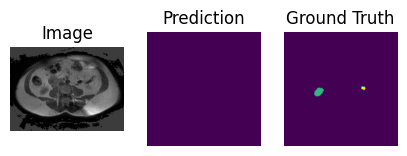

<Figure size 640x480 with 0 Axes>

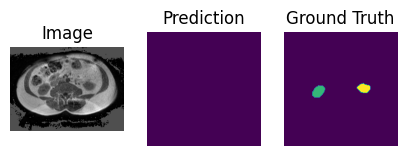

<Figure size 640x480 with 0 Axes>

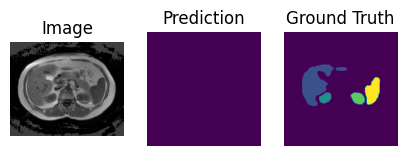

<Figure size 640x480 with 0 Axes>

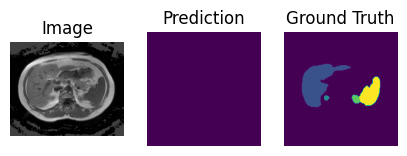

<Figure size 640x480 with 0 Axes>

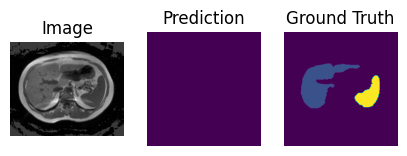

<Figure size 640x480 with 0 Axes>

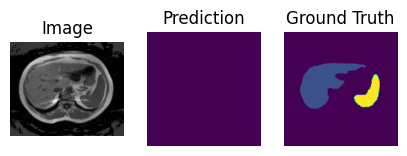

<Figure size 640x480 with 0 Axes>

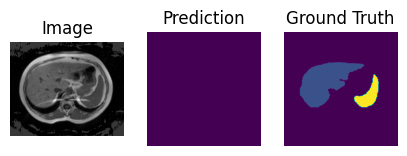

<Figure size 640x480 with 0 Axes>

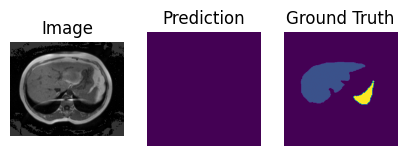

<Figure size 640x480 with 0 Axes>

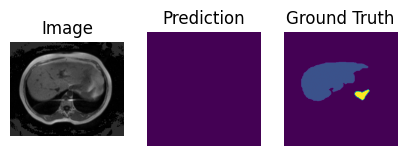

<Figure size 640x480 with 0 Axes>

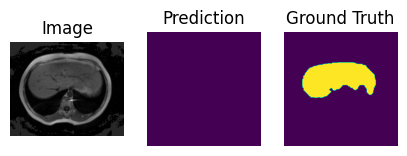

<Figure size 640x480 with 0 Axes>

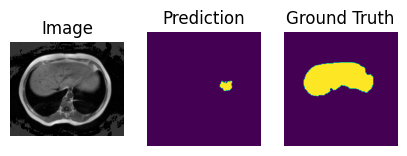

<Figure size 640x480 with 0 Axes>

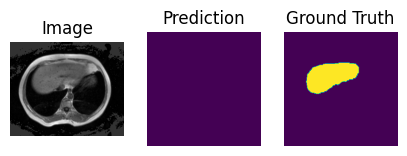

<Figure size 640x480 with 0 Axes>

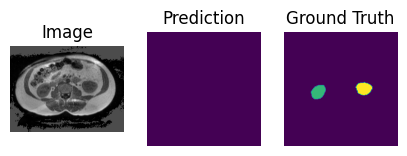

<Figure size 640x480 with 0 Axes>

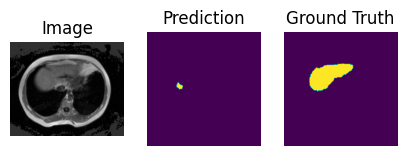

<Figure size 640x480 with 0 Axes>

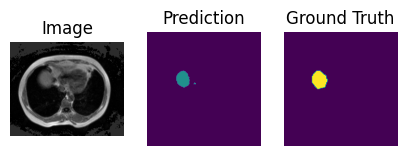

<Figure size 640x480 with 0 Axes>

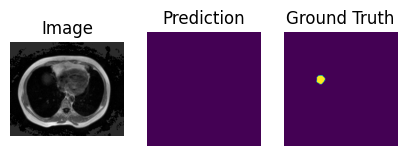

<Figure size 640x480 with 0 Axes>

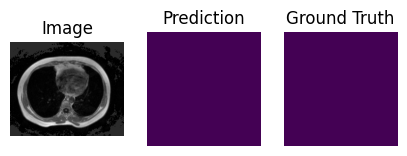

<Figure size 640x480 with 0 Axes>

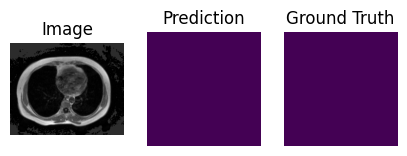

<Figure size 640x480 with 0 Axes>

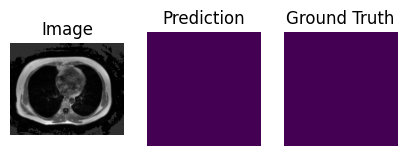

<Figure size 640x480 with 0 Axes>

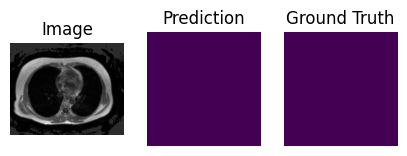

<Figure size 640x480 with 0 Axes>

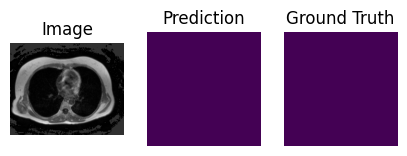

<Figure size 640x480 with 0 Axes>

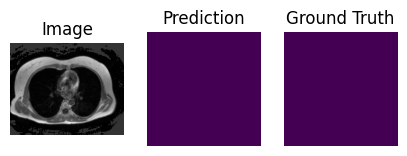

<Figure size 640x480 with 0 Axes>

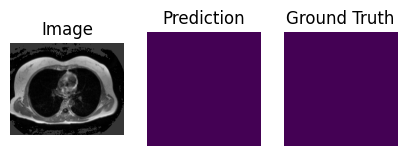

<Figure size 640x480 with 0 Axes>

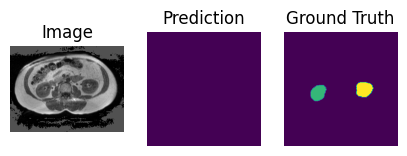

<Figure size 640x480 with 0 Axes>

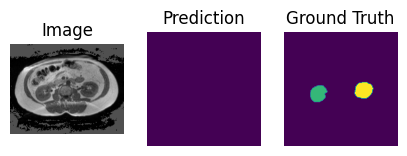

<Figure size 640x480 with 0 Axes>

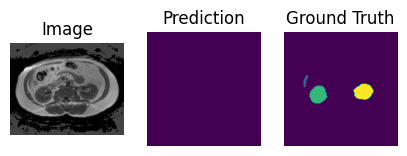

<Figure size 640x480 with 0 Axes>

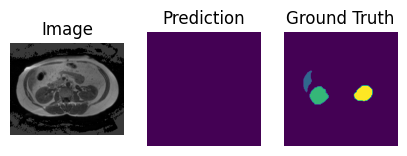

<Figure size 640x480 with 0 Axes>

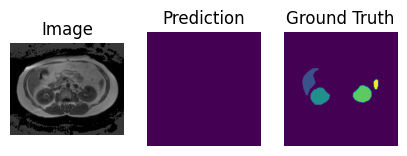

<Figure size 640x480 with 0 Axes>

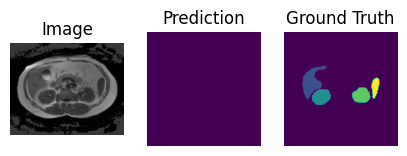

<Figure size 640x480 with 0 Axes>

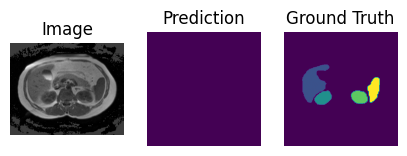

<Figure size 640x480 with 0 Axes>

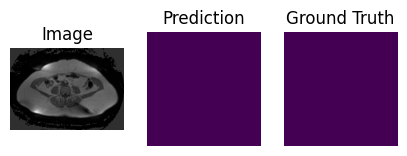

<Figure size 640x480 with 0 Axes>

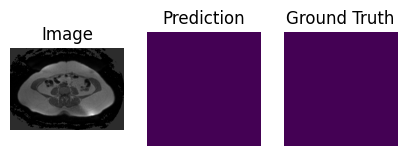

<Figure size 640x480 with 0 Axes>

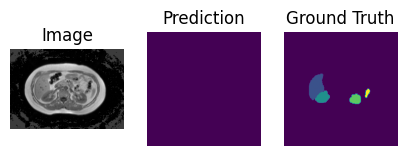

<Figure size 640x480 with 0 Axes>

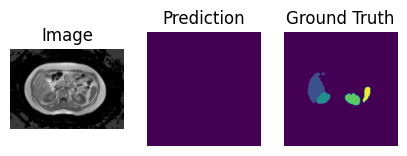

<Figure size 640x480 with 0 Axes>

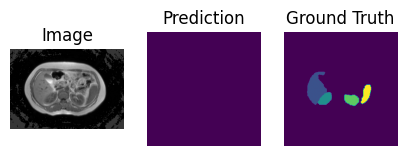

<Figure size 640x480 with 0 Axes>

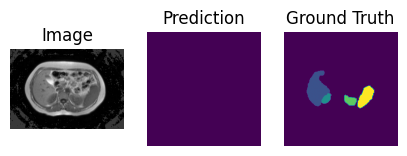

<Figure size 640x480 with 0 Axes>

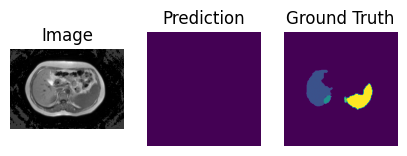

<Figure size 640x480 with 0 Axes>

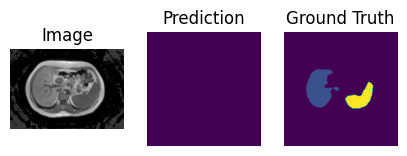

<Figure size 640x480 with 0 Axes>

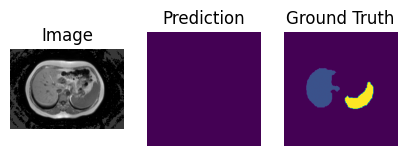

<Figure size 640x480 with 0 Axes>

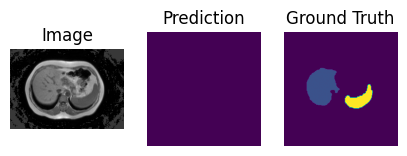

<Figure size 640x480 with 0 Axes>

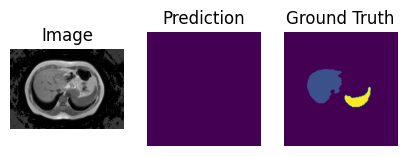

In [33]:
pred_folder_4 = "nnUNet_results/Dataset036_CHAOST2/nnUNetTrainer__nnUNetResEncUNetLPlans__2d/test_NA/fold_4/test_postprocessed/"
test_cases_4 = [5, 15, 17, 19]

gt_files, pred_files, images = get_and_check_files(pred_folder_4, gt_dir, test_cases_4, img_dir, "CHAOST1")
results4 = compute_DSC_fold(pred_folder_4, pred_files, gt_files)
res_4 = results4["mean"]
print(res_4)

show_results(gt_files, pred_files, images)